#### DISCRETE ACTIONS

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gym

# Define a simple policy network
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.fc(x)

# Initialize the CartPole environment
env = gym.make('CartPole-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Initialize the policy network and optimizer
policy_net = PolicyNetwork(state_dim, action_dim)
optimizer = optim.Adam(policy_net.parameters(), lr=0.01)

# Training parameters
num_episodes = 1000
gamma = 0.99  # Discount factor

# Training loop
for episode in range(num_episodes):
    state = env.reset()
    log_probs = []
    rewards = []

    while True:
        # Choose an action based on the policy network
        state = torch.FloatTensor(state)
        action_probs = policy_net(state)
        action = torch.multinomial(action_probs, 1).item()

        # Take the chosen action and observe the next state and reward
        next_state, reward, done, _ = env.step(action)

        # Store the log probability and reward
        log_probs.append(torch.log(action_probs[action]))
        rewards.append(reward)

        state = next_state

        if done:
            break

    # Calculate the discounted returns
    discounted_returns = []
    R = 0
    for r in reversed(rewards):
        R = r + gamma * R
        discounted_returns.insert(0, R)

    # Calculate the loss and update the policy network
    loss = torch.stack(log_probs) * torch.FloatTensor(discounted_returns)
    loss = -loss.sum()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (period + 1) % 10 == 0:
        print(f"Episode {period + 1}/{period}, Loss: {loss.item()}")

# Test the trained policy
state = env.reset()
total_reward = 0
while True:
    action_probs = policy_net(torch.FloatTensor(state))
    action = torch.multinomial(action_probs, 1).item()
    state, reward, done, _ = env.step(action)
    total_reward += reward
    env.render()
    if done:
        break

print(f"Total Reward: {total_reward}")
env.close()


#### CONTINOUS ACTIONS

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gym

# Define a simple policy network
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Tanh()  # Output is in the range [-1, 1] for continuous actions
        )

    def forward(self, x):
        return self.fc(x)

# Initialize the Pendulum environment
env = gym.make('Pendulum-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]  # Continuous action space

# Initialize the policy network and optimizer
policy_net = PolicyNetwork(state_dim, action_dim)
optimizer = optim.Adam(policy_net.parameters(), lr=0.01)

# Training parameters
num_episodes = 1000
gamma = 0.99  # Discount factor

# Training loop
for episode in range(num_episodes):
    state = env.reset()
    log_probs = []
    rewards = []

    while True:
        # Choose an action based on the policy network
        state = torch.FloatTensor(state)
        action_mean = policy_net(state)
        dist = torch.distributions.Normal(action_mean, torch.tensor(0.1))  # Adding some exploration noise
        action = dist.sample()
        action = torch.clamp(action, -1.0, 1.0)  # Clip the action to the valid range

        # Take the chosen action and observe the next state and reward
        next_state, reward, done, _ = env.step(action.numpy())

        # Calculate the log probability of the chosen action
        log_prob = dist.log_prob(action)
        log_probs.append(log_prob)
        rewards.append(reward)

        state = next_state

        if done:
            break

    # Calculate the discounted returns
    discounted_returns = []
    R = 0
    for r in reversed(rewards):
        R = r + gamma * R
        discounted_returns.insert(0, R)

    # Calculate the loss and update the policy network
    loss = torch.stack(log_probs) * torch.FloatTensor(discounted_returns)
    loss = -loss.sum()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (episode + 1) % 10 == 0:
        print(f"Episode {episode + 1}/{num_episodes}, Loss: {loss.item()}")

# Test the trained policy
state = env.reset()
total_reward = 0
while True:
    state = torch.FloatTensor(state)
    action_mean = policy_net(state)
    action = action_mean.detach().numpy()
    state, reward, done, _ = env.step(action)
    total_reward += reward
    env.render()

    if done:
        break

print(f"Total Reward: {total_reward}")
env.close()


### TRADING GAME

In [185]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
from functions import *
from itertools import count
buyer_strategies = ['Honest']
seller_strategies = ['Honest','Honest','Honest','Honest','Honest','Honest','Honest','Honest','Honest','Honest']
nbuyers, nsellers = len(buyer_strategies), len(seller_strategies)
nrounds, nperiods, ntokens, nsteps, gametype, nbuyers, nsellers = 1, 100, 15, 15, '1234', len(buyer_strategies), len(seller_strategies)
R1, R2, R3, R4 = gametype_to_ran(gametype)
game_metadata = [nrounds, nperiods, ntokens, nbuyers, nsellers, nsteps, R1, R2, R3, R4]
db = Database(game_metadata, buyer_strategies, seller_strategies)
rnd = 0
db.reset_round(rnd, ntokens, nbuyers, nsellers, R1, R2, R3, R4)
period = 0
num_states = nsteps
min_frac = 0.01
max_frac = 1.0
action_to_bid_frac = np.linspace(0,1,num_actions)

In [186]:
class TradingEnv(gym.Env):
    def __init__(self, db, nsteps, render_mode = None):
        self.db = db
        self.action_space = spaces.Box(0,1,(1,),dtype=np.float)
        self.observation_space = spaces.Box(0,nsteps,(1,),dtype=np.float)

    def reset(self, rnd):
        self.db.reset_period(rnd)
        observation = np.array([0])
        return observation, None

    def step(self, action, timestep, period, rnd, seed = None, options = None):
        [buyer.next_token() for buyer in self.db.buyers]
        [seller.next_token() for seller in self.db.sellers]
        bid_frac = action.item()
        # convert action to bid
        self.db.buyers[0].next_token()
        min_bid = self.db.buyers[0].value*min_frac
        max_bid = self.db.buyers[0].value*max_frac
        bid = np.round(max_bid * bid_frac + (1-bid_frac)*min_bid,2)
        
        # simulate market
        bids = [buyer.ask(self.db) for buyer in self.db.buyers]
        bids[0] = bid
        asks = [seller.ask(self.db) for seller in self.db.sellers]
        current_ask, current_ask_idx, current_bid, current_bid_idx = current_bid_ask(bids, asks) 
        sale, price, bprofit, sprofit, buy, sell = buy_sell(db, current_bid, current_bid_idx, current_ask, current_ask_idx)
        step_data = [rnd,period,timestep,bids,asks,current_bid,current_bid_idx,current_ask,current_ask_idx,buy,sell,price,sale,bprofit,sprofit]
        self.db.add_step(step_data)
        
        # compute reward, new state
        reward = np.array([0])
        if (sale == 1) and (current_bid_idx == 0):
            reward = np.array([bprofit])
        observation = np.array([timestep + 1])
        
        # check termination 
        if timestep == nsteps-1:
            terminated = True
        else:
            terminated = False
        return observation, reward, terminated, False, None

In [127]:
env = TradingEnv(db, nsteps)
rnd = 0
observation, info = env.reset(rnd)
for period in count():
    for timestep in count(): 
        action = env.action_space.sample()
        observation, reward, done, info, reset_info = env.step(action, timestep, period, rnd)
        print(f"Rnd: {rnd}, Period: {period}, New State: {observation}, Action:{np.round(action,1)}, Reward: {np.round(reward,1)}, Period End: {done}")

        if done:
            # If the episode is done, reset the environment
            print('done')
            observation, info = env.reset(rnd)
            timestep += 1
            break
    if period == nperiods:
        break

# Close the environment when done
env.close()

Rnd: 0, Period: 0, New State: [1], Action:[0.7], Reward: [54.5], Period End: False
Rnd: 0, Period: 0, New State: [2], Action:[0.8], Reward: [47.], Period End: False
Rnd: 0, Period: 0, New State: [3], Action:[0.8], Reward: [0], Period End: False
Rnd: 0, Period: 0, New State: [4], Action:[0.3], Reward: [0], Period End: False
Rnd: 0, Period: 0, New State: [5], Action:[0.5], Reward: [27.1], Period End: False
Rnd: 0, Period: 0, New State: [6], Action:[0.6], Reward: [0], Period End: False
Rnd: 0, Period: 0, New State: [7], Action:[0.3], Reward: [0], Period End: False
Rnd: 0, Period: 0, New State: [8], Action:[0.7], Reward: [0], Period End: False
Rnd: 0, Period: 0, New State: [9], Action:[0.2], Reward: [0], Period End: False
Rnd: 0, Period: 0, New State: [10], Action:[0.1], Reward: [0], Period End: True
done
Rnd: 0, Period: 1, New State: [1], Action:[0.1], Reward: [0], Period End: False
Rnd: 0, Period: 1, New State: [2], Action:[1.], Reward: [42.3], Period End: False
Rnd: 0, Period: 1, New St

Rnd: 0, Period: 10, New State: [4], Action:[0.3], Reward: [63.8], Period End: False
Rnd: 0, Period: 10, New State: [5], Action:[0.5], Reward: [26.8], Period End: False
Rnd: 0, Period: 10, New State: [6], Action:[0.1], Reward: [0], Period End: False
Rnd: 0, Period: 10, New State: [7], Action:[0.1], Reward: [0], Period End: False
Rnd: 0, Period: 10, New State: [8], Action:[0.8], Reward: [0], Period End: False
Rnd: 0, Period: 10, New State: [9], Action:[0.4], Reward: [0], Period End: False
Rnd: 0, Period: 10, New State: [10], Action:[0.4], Reward: [0], Period End: True
done
Rnd: 0, Period: 11, New State: [1], Action:[0.], Reward: [0], Period End: False
Rnd: 0, Period: 11, New State: [2], Action:[0.7], Reward: [54.3], Period End: False
Rnd: 0, Period: 11, New State: [3], Action:[0.4], Reward: [0], Period End: False
Rnd: 0, Period: 11, New State: [4], Action:[0.1], Reward: [72.2], Period End: False
Rnd: 0, Period: 11, New State: [5], Action:[1.], Reward: [15.7], Period End: False
Rnd: 0, Pe

Rnd: 0, Period: 20, New State: [7], Action:[0.2], Reward: [0], Period End: False
Rnd: 0, Period: 20, New State: [8], Action:[0.6], Reward: [0], Period End: False
Rnd: 0, Period: 20, New State: [9], Action:[0.5], Reward: [0], Period End: False
Rnd: 0, Period: 20, New State: [10], Action:[0.8], Reward: [0], Period End: True
done
Rnd: 0, Period: 21, New State: [1], Action:[1.], Reward: [43.], Period End: False
Rnd: 0, Period: 21, New State: [2], Action:[0.6], Reward: [0], Period End: False
Rnd: 0, Period: 21, New State: [3], Action:[0.1], Reward: [0], Period End: False
Rnd: 0, Period: 21, New State: [4], Action:[0.8], Reward: [46.5], Period End: False
Rnd: 0, Period: 21, New State: [5], Action:[0.1], Reward: [0], Period End: False
Rnd: 0, Period: 21, New State: [6], Action:[0.2], Reward: [30.], Period End: False
Rnd: 0, Period: 21, New State: [7], Action:[0.4], Reward: [0], Period End: False
Rnd: 0, Period: 21, New State: [8], Action:[0.7], Reward: [0], Period End: False
Rnd: 0, Period: 2

Rnd: 0, Period: 32, New State: [5], Action:[0.], Reward: [0], Period End: False
Rnd: 0, Period: 32, New State: [6], Action:[0.5], Reward: [27.9], Period End: False
Rnd: 0, Period: 32, New State: [7], Action:[0.7], Reward: [0], Period End: False
Rnd: 0, Period: 32, New State: [8], Action:[0.6], Reward: [0], Period End: False
Rnd: 0, Period: 32, New State: [9], Action:[0.8], Reward: [0], Period End: False
Rnd: 0, Period: 32, New State: [10], Action:[0.6], Reward: [0], Period End: True
done
Rnd: 0, Period: 33, New State: [1], Action:[0.], Reward: [0], Period End: False
Rnd: 0, Period: 33, New State: [2], Action:[0.8], Reward: [48.4], Period End: False
Rnd: 0, Period: 33, New State: [3], Action:[0.4], Reward: [0], Period End: False
Rnd: 0, Period: 33, New State: [4], Action:[0.4], Reward: [60.3], Period End: False
Rnd: 0, Period: 33, New State: [5], Action:[0.1], Reward: [0], Period End: False
Rnd: 0, Period: 33, New State: [6], Action:[0.5], Reward: [27.6], Period End: False
Rnd: 0, Perio

Rnd: 0, Period: 43, New State: [2], Action:[0.2], Reward: [0], Period End: False
Rnd: 0, Period: 43, New State: [3], Action:[0.9], Reward: [40.6], Period End: False
Rnd: 0, Period: 43, New State: [4], Action:[0.3], Reward: [0], Period End: False
Rnd: 0, Period: 43, New State: [5], Action:[0.6], Reward: [24.9], Period End: False
Rnd: 0, Period: 43, New State: [6], Action:[0.3], Reward: [0], Period End: False
Rnd: 0, Period: 43, New State: [7], Action:[0.3], Reward: [0], Period End: False
Rnd: 0, Period: 43, New State: [8], Action:[0.], Reward: [0], Period End: False
Rnd: 0, Period: 43, New State: [9], Action:[0.7], Reward: [0], Period End: False
Rnd: 0, Period: 43, New State: [10], Action:[0.3], Reward: [0], Period End: True
done
Rnd: 0, Period: 44, New State: [1], Action:[0.9], Reward: [44.2], Period End: False
Rnd: 0, Period: 44, New State: [2], Action:[0.], Reward: [0], Period End: False
Rnd: 0, Period: 44, New State: [3], Action:[0.8], Reward: [46.1], Period End: False
Rnd: 0, Perio

Rnd: 0, Period: 54, New State: [7], Action:[0.6], Reward: [0], Period End: False
Rnd: 0, Period: 54, New State: [8], Action:[0.2], Reward: [0], Period End: False
Rnd: 0, Period: 54, New State: [9], Action:[0.4], Reward: [0], Period End: False
Rnd: 0, Period: 54, New State: [10], Action:[0.8], Reward: [0], Period End: True
done
Rnd: 0, Period: 55, New State: [1], Action:[0.9], Reward: [46.7], Period End: False
Rnd: 0, Period: 55, New State: [2], Action:[0.7], Reward: [0], Period End: False
Rnd: 0, Period: 55, New State: [3], Action:[0.9], Reward: [41.1], Period End: False
Rnd: 0, Period: 55, New State: [4], Action:[0.], Reward: [0], Period End: False
Rnd: 0, Period: 55, New State: [5], Action:[0.9], Reward: [17.9], Period End: False
Rnd: 0, Period: 55, New State: [6], Action:[0.8], Reward: [0], Period End: False
Rnd: 0, Period: 55, New State: [7], Action:[0.6], Reward: [0], Period End: False
Rnd: 0, Period: 55, New State: [8], Action:[0.5], Reward: [0], Period End: False
Rnd: 0, Period:

Rnd: 0, Period: 66, New State: [1], Action:[0.7], Reward: [54.5], Period End: False
Rnd: 0, Period: 66, New State: [2], Action:[0.9], Reward: [41.6], Period End: False
Rnd: 0, Period: 66, New State: [3], Action:[0.7], Reward: [0], Period End: False
Rnd: 0, Period: 66, New State: [4], Action:[0.6], Reward: [0], Period End: False
Rnd: 0, Period: 66, New State: [5], Action:[0.8], Reward: [20.6], Period End: False
Rnd: 0, Period: 66, New State: [6], Action:[0.6], Reward: [0], Period End: False
Rnd: 0, Period: 66, New State: [7], Action:[0.8], Reward: [0], Period End: False
Rnd: 0, Period: 66, New State: [8], Action:[0.8], Reward: [0], Period End: False
Rnd: 0, Period: 66, New State: [9], Action:[0.3], Reward: [0], Period End: False
Rnd: 0, Period: 66, New State: [10], Action:[0.2], Reward: [0], Period End: True
done
Rnd: 0, Period: 67, New State: [1], Action:[0.2], Reward: [0], Period End: False
Rnd: 0, Period: 67, New State: [2], Action:[0.6], Reward: [57.8], Period End: False
Rnd: 0, Per

Rnd: 0, Period: 79, New State: [7], Action:[1.], Reward: [0], Period End: False
Rnd: 0, Period: 79, New State: [8], Action:[0.1], Reward: [0], Period End: False
Rnd: 0, Period: 79, New State: [9], Action:[0.8], Reward: [0], Period End: False
Rnd: 0, Period: 79, New State: [10], Action:[0.8], Reward: [0], Period End: True
done
Rnd: 0, Period: 80, New State: [1], Action:[0.7], Reward: [55.4], Period End: False
Rnd: 0, Period: 80, New State: [2], Action:[0.3], Reward: [0], Period End: False
Rnd: 0, Period: 80, New State: [3], Action:[0.8], Reward: [46.9], Period End: False
Rnd: 0, Period: 80, New State: [4], Action:[0.5], Reward: [0], Period End: False
Rnd: 0, Period: 80, New State: [5], Action:[0.3], Reward: [30.], Period End: False
Rnd: 0, Period: 80, New State: [6], Action:[0.2], Reward: [0], Period End: False
Rnd: 0, Period: 80, New State: [7], Action:[0.1], Reward: [0], Period End: False
Rnd: 0, Period: 80, New State: [8], Action:[0.1], Reward: [0], Period End: False
Rnd: 0, Period: 

Rnd: 0, Period: 90, New State: [3], Action:[0.7], Reward: [49.], Period End: False
Rnd: 0, Period: 90, New State: [4], Action:[0.9], Reward: [0], Period End: False
Rnd: 0, Period: 90, New State: [5], Action:[0.], Reward: [0], Period End: False
Rnd: 0, Period: 90, New State: [6], Action:[0.7], Reward: [21.6], Period End: False
Rnd: 0, Period: 90, New State: [7], Action:[0.4], Reward: [0], Period End: False
Rnd: 0, Period: 90, New State: [8], Action:[0.2], Reward: [0], Period End: False
Rnd: 0, Period: 90, New State: [9], Action:[0.1], Reward: [0], Period End: False
Rnd: 0, Period: 90, New State: [10], Action:[0.8], Reward: [0], Period End: True
done
Rnd: 0, Period: 91, New State: [1], Action:[0.8], Reward: [49.1], Period End: False
Rnd: 0, Period: 91, New State: [2], Action:[0.6], Reward: [0], Period End: False
Rnd: 0, Period: 91, New State: [3], Action:[0.6], Reward: [0], Period End: False
Rnd: 0, Period: 91, New State: [4], Action:[0.9], Reward: [39.8], Period End: False
Rnd: 0, Perio

In [187]:
db = Database(game_metadata, buyer_strategies, seller_strategies)
rnd = 0
db.reset_round(rnd, ntokens, nbuyers, nsellers, R1, R2, R3, R4)
period = 0
num_states = nsteps
min_frac = 0.01
max_frac = 1.0
rnd = 0
env = TradingEnv(db, nsteps)

In [192]:
# Test the trained policy
state, _ = env.reset(rnd)
total_reward = 0.0

for timestep in count():
    state = torch.FloatTensor(state)
    action_mean = policy_net(state)
    action = action_mean.detach().numpy()
    state, reward, done, _, _ = env.step(action, timestep, period, rnd)
    total_reward += reward

    if done:
        break

print(f"Total Reward: {total_reward}")
env.close()

Total Reward: [759.74]


In [193]:
env.db.step_data.head(15)

,rnd,period,step,bids,asks,current_bid,current_bid_idx,current_ask,current_ask_idx,buy,sell,price,sale,bprofit,sprofit
0,0,0,0,[61.87],"[23.2, 8.6, 9.8, 12.3, 20.3, 12.4, 29.8, 33.5,...",61.87,0,8.6,1,True,True,35.235,1,63.165,26.635
1,0,0,1,[0.91],"[23.2, 24.3, 9.8, 12.3, 20.3, 12.4, 29.8, 33.5...",0.91,0,9.8,2,True,False,9.800,1,80.900,0.000
2,0,0,2,[0.81],"[23.2, 24.3, 11.4, 12.3, 20.3, 12.4, 29.8, 33....",0.81,0,11.1,9,True,False,11.100,1,69.900,0.000
3,0,0,3,[0.8],"[23.2, 24.3, 11.4, 12.3, 20.3, 12.4, 29.8, 33....",0.80,0,11.4,2,True,False,11.400,1,68.900,0.000
4,0,0,4,[0.74],"[23.2, 24.3, 15.0, 12.3, 20.3, 12.4, 29.8, 33....",0.74,0,12.3,3,True,False,12.300,1,61.300,0.000
5,0,0,5,[0.72],"[23.2, 24.3, 15.0, 24.1, 20.3, 12.4, 29.8, 33....",0.72,0,12.4,5,True,False,12.400,1,60.000,0.000
6,0,0,6,[44.49],"[23.2, 24.3, 15.0, 24.1, 20.3, 15.7, 29.8, 33....",44.49,0,13.5,9,True,True,28.995,1,38.905,15.495
7,0,0,7,[0.67],"[23.2, 24.3, 15.0, 24.1, 20.3, 15.7, 29.8, 33....",0.67,0,15.0,2,True,False,15.000,1,52.100,0.000
8,0,0,8,[58.69],"[23.2, 24.3, 16.0, 24.1, 20.3, 15.7, 29.8, 33....",58.69,0,15.1,8,True,True,36.895,1,29.505,21.795
9,0,0,9,[0.63],"[23.2, 24.3, 16.0, 24.1, 20.3, 15.7, 29.8, 33....",0.63,0,15.7,5,True,False,15.700,1,47.700,0.000


In [194]:
env.db.step_data.tail(15)

,rnd,period,step,bids,asks,current_bid,current_bid_idx,current_ask,current_ask_idx,buy,sell,price,sale,bprofit,sprofit
24943,0,389,0,[9.12],"[23.2, 8.6, 9.8, 12.3, 20.3, 12.4, 29.8, 33.5,...",9.12,0,8.6,1,True,True,8.86,1,89.54,0.26
24944,0,389,1,[2.74],"[23.2, 24.3, 9.8, 12.3, 20.3, 12.4, 29.8, 33.5...",2.74,0,9.8,2,True,False,9.80,1,80.90,0.00
24945,0,389,2,[0.98],"[23.2, 24.3, 11.4, 12.3, 20.3, 12.4, 29.8, 33....",0.98,0,11.1,9,True,False,11.10,1,69.90,0.00
24946,0,389,3,[0.81],"[23.2, 24.3, 11.4, 12.3, 20.3, 12.4, 29.8, 33....",0.81,0,11.4,2,True,False,11.40,1,68.90,0.00
24947,0,389,4,[0.74],"[23.2, 24.3, 15.0, 12.3, 20.3, 12.4, 29.8, 33....",0.74,0,12.3,3,True,False,12.30,1,61.30,0.00
24948,0,389,5,[0.72],"[23.2, 24.3, 15.0, 24.1, 20.3, 12.4, 29.8, 33....",0.72,0,12.4,5,True,False,12.40,1,60.00,0.00
24949,0,389,6,[0.68],"[23.2, 24.3, 15.0, 24.1, 20.3, 15.7, 29.8, 33....",0.68,0,13.5,9,True,False,13.50,1,54.40,0.00
24950,0,389,7,[0.67],"[23.2, 24.3, 15.0, 24.1, 20.3, 15.7, 29.8, 33....",0.67,0,15.0,2,True,False,15.00,1,52.10,0.00
24951,0,389,8,[0.66],"[23.2, 24.3, 16.0, 24.1, 20.3, 15.7, 29.8, 33....",0.66,0,15.1,8,True,False,15.10,1,51.30,0.00
24952,0,389,9,[0.63],"[23.2, 24.3, 16.0, 24.1, 20.3, 15.7, 29.8, 33....",0.63,0,15.7,5,True,False,15.70,1,47.70,0.00


In [196]:
env.db.step_data = env.db.step_data.drop_duplicates(subset=['rnd','period','step'], keep='last')

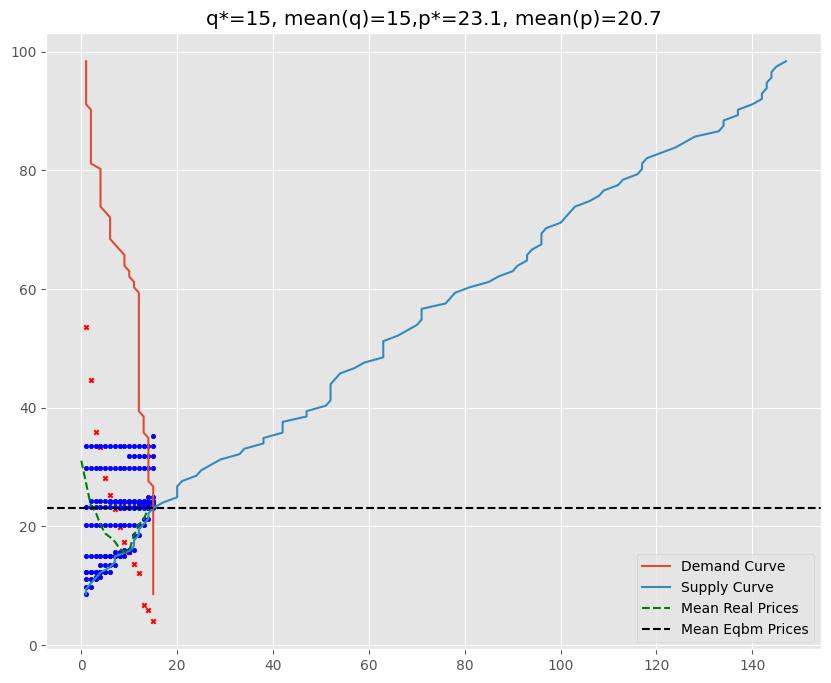

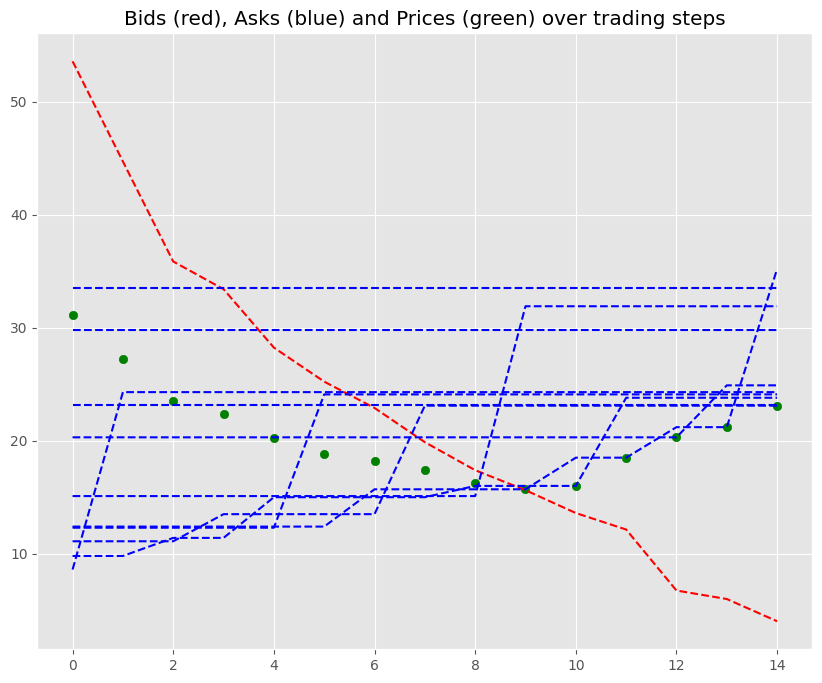

In [197]:
graph_period(env.db, 0, 1)

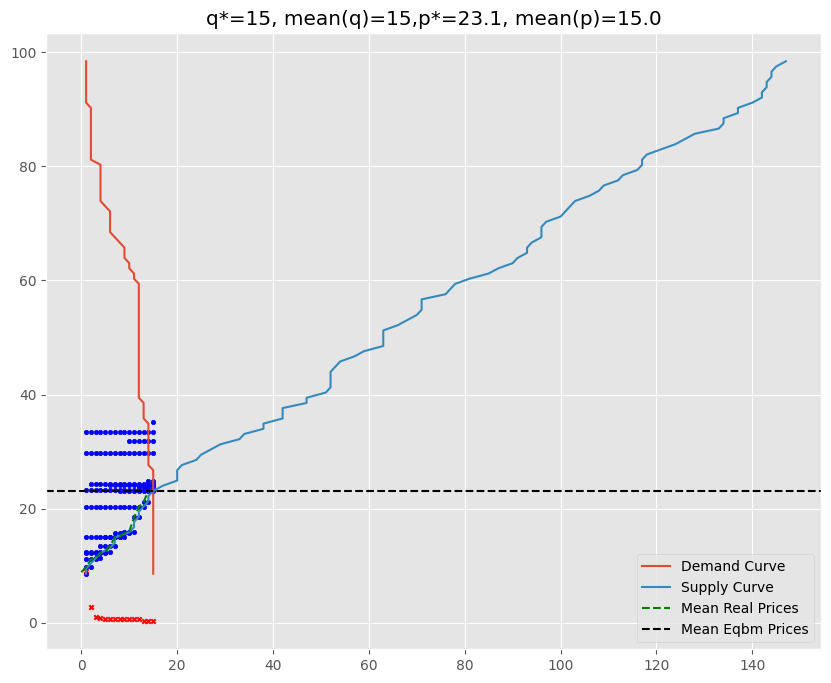

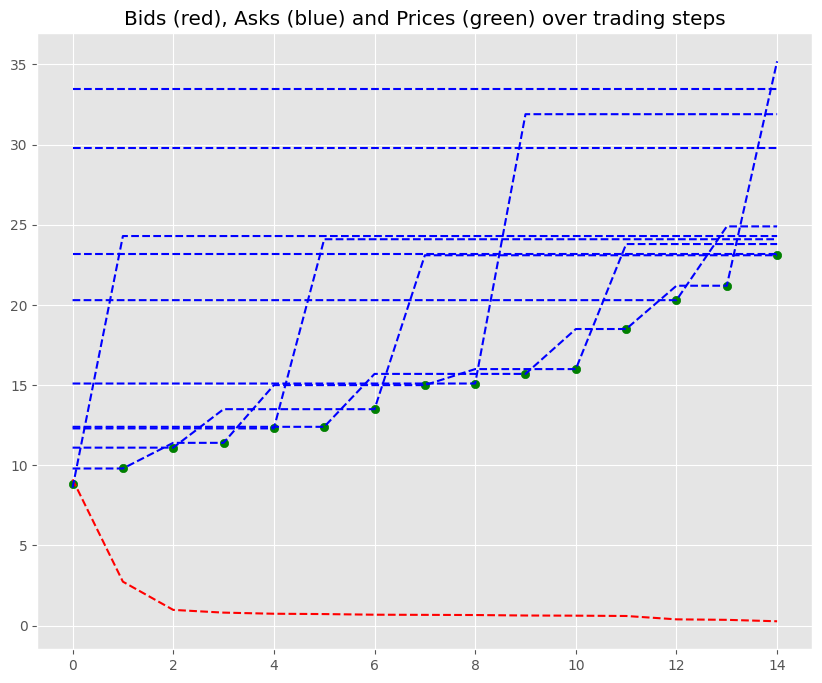

In [198]:
graph_period(env.db, 0, 389)